# Продвинутое машинное обучение: ДЗ 3

![](logo.png)

Задание: [link](https://logic.pdmi.ras.ru/~sergey/teaching/mademl2021.html)<br>

Выполнил: **Полянских Сергей**, апрель 2021

1. [Простой частотный метод](#1.-Простой-частотный-метод)
2. [Частотный метод: биграммы](#2.-Частотный-метод:-биграммы)
3. [MCMC сэмплирование](#3.-MCMC-сэмплирование)
4. [Расшифруйте сообщение](#4.-Расшифруйте-сообщение)
5. [MCMC: n-граммы и метрики](#5.-MCMC:-n-граммы-и-метрики)
6. [Что? Где? Опять?](#6.-Что?-Где?-Опять?)

In [1]:
import re
import random
import pickle
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import beta
from scipy.special import erf
from scipy.sparse import lil_matrix as sparse

from sklearn.metrics import accuracy_score

from chkg_utils import load_players, load_tournaments, load_results
from chkg_utils import prepare_data, mean_correlation_score, top_score
from chkg_utils import get_player_questioncount

## 1. Простой частотный метод

In [2]:
def random_permutation(text):
    vocab = list(set(text))
    perm = np.random.permutation(vocab)
    maps = {v:p for (v,p) in zip(vocab, perm)}
    result = ''.join(map(maps.get, text))
    return result

In [3]:
class HolmesModel:
    def __init__(self, n_gram=1):
        self.n_gram = n_gram
        self.pattern = re.compile(r"[^а-яА-Я]+")
        self.freqs = None

    def fit(self, corpus):
        freqs = Counter()

        for path in corpus:
            with open(path) as f:
                text = f.read()

            text = re.sub(self.pattern, ' ', text).lower()
            for i in range(len(text) - self.n_gram + 1):
                freqs.update([text[i : i+self.n_gram]])

        total = sum(freqs.values())
        for c in freqs:
            freqs[c] /= total

        self.freqs = freqs
        return self

    def predict(self, text):
        freqs = Counter()
        text = text.lower()
        for i in range(len(text) - self.n_gram + 1):
            freqs.update([text[i : i+self.n_gram]])

        total = sum(freqs.values())
        for c in freqs:
            freqs[c] /= total

        result = []
        for i in range(len(text) - self.n_gram + 1):
            c = text[i : i+self.n_gram]
            f = freqs[c]
            c_close = None
            f_close = 1
            for r, fr in self.freqs.items():
                if abs(fr - f) < f_close:
                    c_close = r
                    f_close = abs(fr - f)
            result.append(c_close[0])
            
        result.append(c_close[1:])
            
        return ''.join(result)

In [4]:
holmes = HolmesModel(n_gram=1)
holmes.fit(['data/AnnaKarenina.txt','data/WarAndPeace.txt'])

In [5]:
with open('data/AnnaKarenina.txt') as f:
    text = f.read()

lens = [100, 1000, 10000, 100000, 200000, 300000, 400000, 500000]
scores = []
for len_text in lens:
    sample = re.sub(holmes.pattern, ' ', text[1000 : 1000+len_text]).lower()

    print(f'\n------------ Длина входного текста: {len_text} ------------')
    print('Вход:')
    print(sample[:100])

    perm = random_permutation(sample)
    predict = holmes.predict(perm)
    score = accuracy_score(list(sample), list(predict))
    scores.append(score)

    print('Результат:')
    print(predict[:100])


------------ Длина входного текста: 100 ------------
Вход:
 может поравняться с этим а в европе кто представит хоть что нибудь подобное ф м достоевски
Результат:
 рожао соррируориу и жоср р и аироса уоо срасиорисо жоор жоо рсужср сосоуроа ж р соиооаииус

------------ Длина входного текста: 1000 ------------
Вход:
 может поравняться с этим а в европе кто представит хоть что нибудь подобное ф м достоевский находил
Результат:
 кожет зорасежтжсж с ютнк а с есрозе уто зреястаснт жотж что еныкяж зояоыеое ф к яостоессунь еажоянв

------------ Длина входного текста: 10000 ------------
Вход:
 может поравняться с этим а в европе кто представит хоть что нибудь подобное ф м достоевский находил
Результат:
 дожет ьолнлабтжиб и этад н л еллоье дто ьлеяитнлат жотж что аачяяж ьояочаое щ д яоитоелидаь анжояар

------------ Длина входного текста: 100000 ------------
Вход:
 может поравняться с этим а в европе кто представит хоть что нибудь подобное ф м достоевский находил
Результат:
 дожет поравньтьть т 

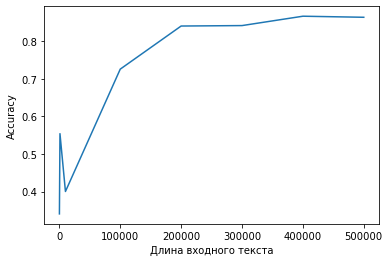

In [6]:
plt.xlabel('Длина входного текста')
plt.ylabel('Accuracy')
plt.plot(lens, scores)

**Выводы:**
    
- простой частотный метод на 1-граммах ожидаемо слабый
- даже если подавать на проверку куски исходного корпуса (в надежде на переобучение), то их длина должна быть очень большой, чтобы качество стало приемлемым 

## 2. Частотный метод: биграммы

In [7]:
holmes = HolmesModel(n_gram=2)
holmes.fit(['data/AnnaKarenina.txt', 'data/WarAndPeace.txt'])

In [8]:
with open('data/AnnaKarenina.txt') as f:
    text = f.read()

lens = [100, 1000, 10000, 100000, 200000, 300000, 400000, 500000]
scores = []
for len_text in lens:
    sample = re.sub(holmes.pattern, ' ', text[1000 : 1000+len_text]).lower()

    print(f'\n------------ Длина входного текста: {len_text} ------------')
    print('Вход:')
    print(sample[:100])

    perm = random_permutation(sample)
    predict = holmes.predict(perm)
    score = accuracy_score(list(sample), list(predict))
    scores.append(score)

    print('Результат:')
    print(predict[:100])


------------ Длина входного текста: 100 ------------
Вход:
 может поравняться с этим а в европе кто представит хоть что нибудь подобное ф м достоевски
Результат:
ояяяяооояяояяяояяяяяяяяяояяяяяояяяяояяооояяяяояояяояяяоояяоояяяяяяооояояяяоояяоояояоооояяя 

------------ Длина входного текста: 1000 ------------
Вход:
 может поравняться с этим а в европе кто представит хоть что нибудь подобное ф м достоевский находил
Результат:
 чдрпчярп уппурууу дрдрпяд акппп пу гпатяргчуечупдчччрркпуатттпучукярдррутд уу ярр еадпчрпч т пчдпдр

------------ Длина входного текста: 10000 ------------
Вход:
 может поравняться с этим а в европе кто представит хоть что нибудь подобное ф м достоевский находил
Результат:
т оск яурннзоича г  че мус  г неьзм  е  яи нрачнк   двчвси  я яйоавяу с а с ортуас а снтоам яншд де 

------------ Длина входного текста: 100000 ------------
Вход:
 может поравняться с этим а в европе кто представит хоть что нибудь подобное ф м достоевский находил
Результат:
зсс оаткзвсилк тюь см

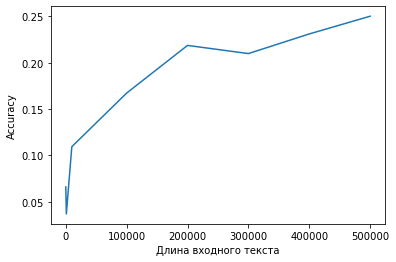

In [9]:
plt.xlabel('Длина входного текста')
plt.ylabel('Accuracy')
plt.plot(lens, scores)

**Выводы:**

- частотный метод на 2-граммах также ожидаемо слабый (слабее 1-грамм) по понятным причинам - биграм очень много
- одним словом (одним из предсказанных выше) - полный уожосс
- инференс биграммного метода очевидно можно было бы улучшать, но в радикально картина вряд ли бы улучшилась

## 3. MCMC сэмплирование

Рассмотрим чтение текста слева направо как марковскую цепь последовательных переходом от биграммы к биграмме.<br>
Нам требуется найти наилучшую в плане likelihood перестановку символов, приводящую к осмысленному результату. В качестве вероятностного пространства возьмем дискретное пространство всех перестановок символов, в качестве априорного распределения - равномерное, так как априорных знаний о шифре у нас по умолчанию нет.

**fit модели**: Составим матрицу переходов от биграмме к биграмме: $L(x, y) = \log prob(x \rightarrow y)$.

**predict модели:** собственно, MCMC блуждание по перестановкам символов. Нам, впрочем, MCMC здесь нужно только чтобы по сути найти argmax распределения, а не его само как таковое. Перестановки естесственно считать "близкими", если они мало отличаются как отображения - на транспозицию например.

In [10]:
class MCMCModel:
    def __init__(self, n_gram=1):
        self.n_gram = n_gram
        self.pattern = re.compile(r"[^а-яА-Я]+")
        self.token2idx = None
        self.idx2token = None
        self.vocab = None
        self.P = None

    def fit(self, corpus):
        stats = defaultdict(Counter)
        vocab = set()

        for path in corpus:
            with open(path) as f:
                text = f.read()
                
            text = re.sub(self.pattern, ' ', text).lower()
            vocab |= set(text)
            for i in range(len(text) - self.n_gram):
                curr_gram = text[i : i+self.n_gram]
                next_gram = text[i+1 : i+self.n_gram+1]
                stats[curr_gram].update([next_gram])
            if next_gram not in stats:
                stats[next_gram] = Counter()

        tokens = list(stats.keys())
        n_tokens = len(stats)
        idx2token = {i:t for i, t in enumerate(tokens)}
        token2idx = {t:i for i, t in enumerate(tokens)}

        P = sparse((n_tokens, n_tokens))
        for i in range(n_tokens):
            t = idx2token[i]
            s = stats[t]
            for st, sc in s.items():
                if st in token2idx:
                    j = token2idx[st]
                    P[i, j] = sc

        self.vocab = vocab
        self.token2idx = token2idx
        self.idx2token = idx2token
        self.P = sparse(P / (P.sum(axis=1) + 1e-12))

    def predict(self, text, max_iters=10000, f0=None, n_chains=10, seed=None):
        random.seed(seed)
        np.random.seed(seed)

        vocab = list(set(text))
        f = f0 or self.sample_mapping(vocab)
        trans = ''.join([f[c] for c in text])
        ll_init = self.log_likelihood(trans)
        ll_best = ll_init
        f_best = f
        accepts = 0

        for _ in tqdm(range(n_chains)):
            ll = ll_init
            for i in range(max_iters):
                f_new = self.transpose_mapping(f)
                trans_new = ''.join([f_new[c] for c in text])
                ll_new = self.log_likelihood(trans_new)

                if (ll_new > ll_best):
                    ll_best = ll_new
                    f_best = f_new

                if (ll_new > ll) or (np.random.rand() < np.exp(ll_new - ll)):
                    ll = ll_new
                    f = f_new
                    accepts += 1
        
        trans = ''.join([f_best[c] for c in text])

        return trans, ll_best, f_best, accepts/(max_iters*n_chains)

    def transpose_mapping(self, f):
        c1 = random.sample(f.keys(), 1)[0]
        f1 = f[c1]
        f2 = random.sample(self.vocab, 1)[0]
        g = f.copy()

        if f2 in f.values():
            c2 = list(f.keys())[list(f.values()).index(f2)]
            g[c1], g[c2] = f2, f1
        else:
            g[c1] = f2

        return g
    
    def sample_mapping(self, vocab):
        samples = random.sample(self.vocab, len(vocab))
        f = {c:m for c, m in zip(vocab, samples)}
        return f
    
    def log_likelihood(self, text):
        ll = 0.0

        for i in range(len(text) - self.n_gram):
            curr_gram = text[i : i+self.n_gram]
            next_gram = text[i+1 : i+self.n_gram+1]
            
            curr_id = self.token2idx.get(curr_gram, -1)
            next_id = self.token2idx.get(next_gram, -1)
            lp = self.P[curr_id, next_id] if (curr_id >= 0) and (next_id >= 0) else 0
            ll += np.log(lp or 1e-12)

        return ll

In [11]:
mcmc = MCMCModel(n_gram=2)
mcmc.fit(['data/AnnaKarenina.txt', 'data/WarAndPeace.txt'])

## 4. Расшифруйте сообщение

Поможем MCMC и стартанем из меппинга, даваемого частотным методом.

In [12]:
text = 'დჳჵჂႨშႼႨშჂხჂჲდႨსႹႭჾႣჵისႼჰႨჂჵჂႨႲႹႧჲჂႨსႹႭჾႣჵისႼჰႨჲდႩჳჲႨჇႨႠჲႹქႹႨჳႹႹჱჶდსჂႽႨႩႹჲႹႭႼჰႨჵდქႩႹႨႲႭႹႧჂჲႣჲიႨჳႩႹႭდდႨშჳდქႹႨშႼႨშჳდႨჳხდჵႣჵჂႨႲႭႣშჂჵისႹႨჂႨႲႹჵჇႧჂჲდႨჾႣႩჳჂჾႣჵისႼჰႨჱႣჵჵႨეႣႨႲႹჳჵდხსდდႨႧდჲშდႭჲႹდႨეႣხႣსჂდႨႩჇႭჳႣႨႾႹჲႽႨႩႹსდႧსႹႨႽႨსჂႧდქႹႨსდႨႹჱდჶႣნ'

In [13]:
train_freqs = HolmesModel().fit(['data/AnnaKarenina.txt', 'data/WarAndPeace.txt']).freqs
train_freqs = sorted(train_freqs.items(), key=lambda item: -item[1])

text_freqs = Counter(text)
text_freqs = sorted(text_freqs.items(), key=lambda item: -item[1])
text_freqs = [(c, r/len(text)) for c, r in text_freqs]

n_min = min(len(train_freqs), len(text_freqs))
f0 = {c2: c1 for (c1, f1), (c2, f2) in zip(train_freqs[:n_min], text_freqs[:n_min])}

In [14]:
pred, ll, f, r = mcmc.predict(text, max_iters=10000, f0=f0, n_chains=30, seed=9)

100%|██████████| 30/30 [04:23<00:00,  8.77s/it]


In [15]:
print('log_likelihood:', ll)
print('accept rate:', r)
print('result:\n', pred)

log_likelihood: -495.98061579350923
accept rate: 0.03435
result:
 если вы видите нормальный или почти нормальный текст у этого сообщения который легко прочитать скорее всего вы все сделали правильно и получите максимальный балл за последнее четвертое задание курса хотя конечно я ничего не обещаю


Ну вроде бы получилось :)

## 5. MCMC: n-граммы и метрики

Рассмотрим два гиперпараметра: 
- длина входной последовательности
- длина n-граммы.

Тестировать результаты на данном выше предложении не имеет смысла, так как оно раскодировалось идеально.<br>
В качестве тестового текста возьмем отрывок из "Преступления и наказания".<br>
Будем постепенно увеличивать длину текста и смотреть, как изменяется качество (accuracy) дешифровки при разных значениях n_gram = 1,2,3,4.

In [16]:
text = \
    'озабоченный и серьезный проснулся разумихин на другой день в восьмом часу много новых и непредвиденных '+\
    'недоумений очутилось вдруг у него в это утро он и не воображал прежде что когда нибудь так проснется'+\
    'он помнил до последних подробностей всё вчерашнее и понимал что с ним совершилось что то необыденное что он' +\
    'принял в себя одно доселе совсем неизвестное ему впечатление и непохожее на все прежние в то же время он ясно'+\
    'сознавал чтомечта загоревшаяся в голове его в высшей степени неосуществима до того неосуществима что ему даже'+\
    'стало стыдно ее и он поскорей перешел к другим более насущным заботам и недоумениям оставшимся ему в наследство'+ \
    'после растреклятого вчерашнего дня'

In [17]:
vocab = list(set(text))
codes = vocab.copy()
random.shuffle(codes)

encoder = {c:r for c, r in zip(vocab, codes)}
decoder = {r:c for c, r in encoder.items()}

In [18]:
text_enc = ''.join([encoder[c] for c in text])

### n_gram=1

In [19]:
mcmc = MCMCModel(n_gram=1)
mcmc.fit(['data/AnnaKarenina.txt', 'data/WarAndPeace.txt'])

scores1 = []
ls = []

for l in range(10, 100, 10):
    text_trunc = text[:l]
    text_trunc_enc = text_enc[:l]
    pred, _, _, _ = mcmc.predict(text_trunc_enc, max_iters=10000, f0=None, n_chains=30, seed=9)
    score = accuracy_score(list(text_trunc), list(pred))
    
    scores1.append(score)
    ls.append(l)

100%|██████████| 30/30 [01:42<00:00,  3.40s/it]


### n_gram=2

In [20]:
mcmc = MCMCModel(n_gram=2)
mcmc.fit(['data/AnnaKarenina.txt', 'data/WarAndPeace.txt'])

scores2 = []
ls = []

for l in range(10, 100, 10):
    text_trunc = text[:l]
    text_trunc_enc = text_enc[:l]
    pred, _, _, _ = mcmc.predict(text_trunc_enc, max_iters=10000, f0=None, n_chains=30, seed=9)
    score = accuracy_score(list(text_trunc), list(pred))
    
    scores2.append(score)
    ls.append(l)

100%|██████████| 30/30 [01:42<00:00,  3.41s/it]


### n_gram=3

In [21]:
mcmc = MCMCModel(n_gram=3)
mcmc.fit(['data/AnnaKarenina.txt', 'data/WarAndPeace.txt'])

scores3 = []
ls = []

for l in range(10, 100, 10):
    text_trunc = text[:l]
    text_trunc_enc = text_enc[:l]
    pred, _, _, _ = mcmc.predict(text_trunc_enc, max_iters=10000, f0=None, n_chains=30, seed=9)
    score = accuracy_score(list(text_trunc), list(pred))
    
    scores3.append(score)
    ls.append(l)

100%|██████████| 30/30 [01:33<00:00,  3.12s/it]


### n_gram=4

In [22]:
mcmc = MCMCModel(n_gram=4)
mcmc.fit(['data/AnnaKarenina.txt', 'data/WarAndPeace.txt'])

scores4 = []
ls = []

for l in range(10, 100, 10):
    text_trunc = text[:l]
    text_trunc_enc = text_enc[:l]
    pred, _, _, _ = mcmc.predict(text_trunc_enc, max_iters=10000, f0=None, n_chains=30, seed=9)
    score = accuracy_score(list(text_trunc), list(pred))
    
    scores4.append(score)
    ls.append(l)

100%|██████████| 30/30 [01:27<00:00,  2.91s/it]


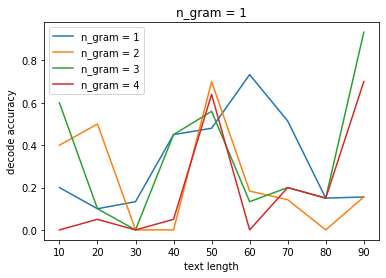

In [32]:
plt.xlabel('text length')
plt.ylabel('decode accuracy')
plt.title('n_gram = 1')
plt.plot(ls, scores1, label='n_gram = 1')
plt.plot(ls, scores2, label='n_gram = 2')
plt.plot(ls, scores3, label='n_gram = 3')
plt.plot(ls, scores4, label='n_gram = 4')
plt.legend()
plt.show()

**Выводы:**

Довольно сложно сказать как n_gram влияет на общее качество. Там, где видна существенная просадка, дело скорее всего в том, что сэмплироваине не сошлось, что случается не редко.
В целом по ощущениям кажется, что n_gram={2,3} дают оптимальное качество.

## 6. Что? Где? Опять?

(вместо бонуса)

Придумать сходу, где MCMC декодирование последовательностей может еще возникнуть сразу не вышло (разве что пальцем в небо - теория информации, биоинженерия и т.п).

Но лично мне крайне интересно теперь реализовать идею, предложенную в решении предыдущего ДЗ https://nbviewer.jupyter.org/github/polaris-kra/aml-2021/blob/main/homework_2.ipynb - постараться получить рейтинги игроков в "Что? Где? Когда?" не в виде конечных чисел, а в виде распределений.

Как было тогда показано, такая система рейтингов имеет ряд преимуществ, главным из которых является естественное занижение рейтингов у мало игравших игроков - для этого в качестве итогового рейтинга игрока следует взять $t$-й квантиль распределения его рейтинга, где $t$ - небольное число. При этом пропадает необходимость в искусственной фильтрации новичков, чтобы они не искажали рейтинги, и рейтинги будут у всех - и  новичков, и профессионалов.

**Данные**

In [34]:
players = load_players('data/players.pkl')
tournaments = load_tournaments('data/tournaments.pkl')
team_results = load_results('data/results.pkl', tournaments)

100%|██████████| 5528/5528 [00:08<00:00, 648.71it/s]  


In [35]:
train_results = team_results[team_results['year'] == 2019]
test_results  = team_results[team_results['year'] == 2020]

**Модель**

Модель сделаем попроще, чтобы продемонстрировать, что идея работает, но не было бы серьезных проблем с сэмплированием.

Имеем

$$
p(\theta | D) \sim p(D | \theta)p(\theta),
$$

где $\theta = (\bar{z}, \bar{u})$ - вектор параметров, составленный из векторов рейтингов игроков $\bar{z}$ и рейтингов ворпосов $\bar{u}$, которые мы предполагаем случайными величинами, распределенными на $(-\infty,\infty)$. 

Далее, будем предполагать, что априорное распределение - нормальное с центром в 0. Расчеты показали, что без такой регуляризации распределения рейтингов ничем не ограничены и "разрастаются" в обе стороны при продолжительном семплировании. С регуляризацией такой проблемы нет. 

Тогда окончательно:

$$
\ln p(\theta | D) \sim \ln p(D | \theta) + \ln p(\theta) = \sum\limits_{d \in D}\ln p(d | \bar{z}, \bar{u}) - \lambda \left(\| z \|^2 + \|u\|^2\right),
$$

где $d$ - точка данных: такая-то команда взяла или не взяла такой-то вопрос. 

Собственно, сама модель будет состоять в следующем: силой команды считаем сумму рейтингов ее членов, из которой затем вычитается рейтинг вопроса. На результат накладывается нормальный гауссовский шум, имитирующий случайность/удачу и т.п. Если получившееся значение больше нуля, то команда взяла вопрос, если меньше либо равно, то нет:

$$
\DeclareMathOperator{\erf}{erf}
p(d = 0 |  \bar{z}, \bar{u}) = \int\limits_{-\infty}^0 N(t | \sum_{p\in t}z_{pq} - u_q, \sigma^2)dt =
\frac{1}{2} + \frac{1}{2}\erf\left(-\frac{\sum_{p\in t}z_{pq} - u_q}{\sigma\sqrt{2}}\right) ,
$$
$$
p(d = 1 |  \bar{z}, \bar{u}) = \int\limits_0^{\infty} N(t | \sum_{p\in t}z_{pq} - u_q, \sigma^2)dt =
\frac{1}{2} - \frac{1}{2}\erf\left(-\frac{\sum_{p\in t}z_{pq} - u_q}{\sigma\sqrt{2}}\right)  
.
$$

Здесь $\sigma$ - гиперпараметр, положим для простоты заданным свыше, скажем, равным 1.
В этих предположениях модель оказывается полностью определенной и достаточно простой для сэмплирования по Метрополису.

In [36]:
player_questioncount = get_player_questioncount(train_results)
olders = player_questioncount[player_questioncount['question_count'] > 1300]['player_id'].values

In [37]:
train_data, player_inv_map, question_inv_map = prepare_data(train_results, filter_players=olders)
train_data.set_index(['player_id', 'question_id'], inplace=True)
train_data.head()

gameteam_id  win
player_id question_id                  
0         0              455564772    1
          1              455564772    1
          2              455564772    1
          3              455564772    1
          4              455564772    1

In [38]:
def create_param_dataframes(p_values, q_values):
    p_ratings = pd.DataFrame({'player_rating': p_values})
    p_ratings.index.name = 'player_id'
    q_ratings = pd.DataFrame({'question_rating': q_values})
    q_ratings.index.name = 'question_id'
    
    return p_ratings, q_ratings


def calc_log_likelihood(data, p_ratings, q_ratings, sigma=1, p_lam=1, q_lam=1):
    data = data.join(p_ratings) \
               .join(q_ratings) \
               .groupby(['gameteam_id', 'question_id']) \
               .agg({'win': 'first', 'player_rating': 'sum',  'question_rating': 'first'}) \
               .reset_index()

    data['win_rating'] = data['player_rating'] - data['question_rating'] 
    data['value'] = -data['win_rating'] / (sigma * np.sqrt(2))
    data['value'] =  data['value'].apply(erf)
    data.loc[data['win'] == 1, 'value'] *= -1
    
    if np.any(data['value'].values == -1):
        return -np.inf

    data['value'] = np.log(0.5 + 0.5*data['value'])

    log_likelihood = data['value'].values.sum() - \
                     p_lam*np.linalg.norm(p_ratings['player_rating'].values)**2 - \
                     q_lam*np.linalg.norm(q_ratings['question_rating'].values)**2
    del data
    
    return log_likelihood


def step_sample(x, q_sigma=0.1):
    return x + np.random.normal(0, q_sigma, len(x))


def metropolis(data, p_ratings, q_ratings, m_sigma,
               n_iter, q_sigma=0.1, p_lam=1.0, q_lam=1.0, random_state=None):
    # init randomness
    random.seed(random_state)
    np.random.seed(random_state)
    
    # set initial point in parameter space
    n_players = len(p_ratings)
    n_questions = len(q_ratings)
    p_ratings_curr, q_ratings_curr = \
        create_param_dataframes(np.random.rand(n_players),
                                np.random.rand(n_questions))
    l_curr = calc_log_likelihood(data, p_ratings_curr, q_ratings_curr, sigma=m_sigma, p_lam=p_lam, q_lam=q_lam)
    p_samples = [p_ratings_curr['player_rating'].values.copy()]
    q_samples = [q_ratings_curr['question_rating'].values.copy()]
    accepted = 0
    log_infs = 0

    # sample it!
    for i in tqdm(range(n_iter)):
        p_new = step_sample(p_ratings_curr['player_rating'].values, q_sigma=q_sigma)
        q_new = step_sample(q_ratings_curr['question_rating'].values, q_sigma=q_sigma)
        p_ratings_new, q_ratings_new = create_param_dataframes(p_new, q_new)
        
        l_new = calc_log_likelihood(data, p_ratings_new, q_ratings_new, sigma=m_sigma, p_lam=p_lam, q_lam=q_lam)
        
        if np.isinf(l_new):
            log_infs += 1
        else:
            if (l_new > l_curr) or (np.random.rand() < np.exp(l_new - l_curr)):
                p_samples.append(p_ratings_new['player_rating'].values.copy())
                q_samples.append(q_ratings_new['question_rating'].values.copy())
                p_ratings_curr = p_ratings_new
                q_ratings_curr = q_ratings_new
                l_curr = l_new
                accepted += 1

        if (i > 0) and (i % 100 == 0):
            print('accept rate, %: ', accepted)
            print('log inf rate, %: ', log_infs)
            accepted = 0
            log_infs = 0

    return np.array(p_samples), np.array(q_samples)

In [39]:
p_ratings, q_ratings = create_param_dataframes(np.zeros(len(player_inv_map)), 
                                               np.zeros(len(question_inv_map)))

In [40]:
p_ratings.shape, q_ratings.shape

((2116, 1), (27271, 1))

In [41]:
p_samples, q_samples = \
    metropolis(train_data, p_ratings, q_ratings, m_sigma=0.9999,
               n_iter=10000, q_sigma=0.001, p_lam=0.1, q_lam=0.1, random_state=9)

  1%|          | 101/10000 [01:04<1:43:56,  1.59it/s]

accept rate, %:  47
log inf rate, %:  0


  2%|▏         | 201/10000 [02:07<1:43:37,  1.58it/s]

accept rate, %:  47
log inf rate, %:  0


  3%|▎         | 301/10000 [03:10<1:42:48,  1.57it/s]

accept rate, %:  44
log inf rate, %:  0


  4%|▍         | 401/10000 [04:14<1:40:42,  1.59it/s]

accept rate, %:  48
log inf rate, %:  0


  5%|▌         | 501/10000 [05:17<1:38:50,  1.60it/s]

accept rate, %:  56
log inf rate, %:  0


  6%|▌         | 601/10000 [06:20<1:36:43,  1.62it/s]

accept rate, %:  55
log inf rate, %:  0


  7%|▋         | 701/10000 [07:22<1:36:28,  1.61it/s]

accept rate, %:  49
log inf rate, %:  0


  8%|▊         | 801/10000 [08:25<1:35:13,  1.61it/s]

accept rate, %:  49
log inf rate, %:  0


  9%|▉         | 901/10000 [09:27<1:34:33,  1.60it/s]

accept rate, %:  49
log inf rate, %:  0


 10%|█         | 1001/10000 [10:29<1:31:50,  1.63it/s]

accept rate, %:  48
log inf rate, %:  0


 11%|█         | 1101/10000 [11:31<1:30:28,  1.64it/s]

accept rate, %:  54
log inf rate, %:  0


 12%|█▏        | 1201/10000 [12:35<1:34:36,  1.55it/s]

accept rate, %:  45
log inf rate, %:  0


 13%|█▎        | 1301/10000 [13:38<1:32:47,  1.56it/s]

accept rate, %:  53
log inf rate, %:  0


 14%|█▍        | 1401/10000 [14:42<1:30:28,  1.58it/s]

accept rate, %:  54
log inf rate, %:  0


 15%|█▌        | 1501/10000 [15:45<1:29:12,  1.59it/s]

accept rate, %:  46
log inf rate, %:  0


 16%|█▌        | 1601/10000 [16:49<1:28:09,  1.59it/s]

accept rate, %:  48
log inf rate, %:  0


 17%|█▋        | 1701/10000 [17:52<1:28:19,  1.57it/s]

accept rate, %:  45
log inf rate, %:  0


 18%|█▊        | 1801/10000 [18:56<1:27:07,  1.57it/s]

accept rate, %:  54
log inf rate, %:  0


 19%|█▉        | 1901/10000 [20:00<1:25:35,  1.58it/s]

accept rate, %:  46
log inf rate, %:  0


 20%|██        | 2001/10000 [21:03<1:24:07,  1.58it/s]

accept rate, %:  54
log inf rate, %:  0


 21%|██        | 2101/10000 [22:06<1:23:08,  1.58it/s]

accept rate, %:  50
log inf rate, %:  0


 22%|██▏       | 2201/10000 [23:10<1:21:50,  1.59it/s]

accept rate, %:  48
log inf rate, %:  0


 23%|██▎       | 2301/10000 [24:13<1:21:20,  1.58it/s]

accept rate, %:  60
log inf rate, %:  0


 24%|██▍       | 2401/10000 [25:17<1:20:26,  1.57it/s]

accept rate, %:  47
log inf rate, %:  0


 25%|██▌       | 2501/10000 [26:20<1:19:28,  1.57it/s]

accept rate, %:  52
log inf rate, %:  0


 26%|██▌       | 2601/10000 [27:23<1:18:44,  1.57it/s]

accept rate, %:  47
log inf rate, %:  0


 27%|██▋       | 2701/10000 [28:27<1:17:01,  1.58it/s]

accept rate, %:  39
log inf rate, %:  0


 28%|██▊       | 2801/10000 [29:31<1:17:15,  1.55it/s]

accept rate, %:  47
log inf rate, %:  0


 29%|██▉       | 2901/10000 [30:34<1:14:30,  1.59it/s]

accept rate, %:  52
log inf rate, %:  0


 30%|███       | 3001/10000 [31:36<1:13:32,  1.59it/s]

accept rate, %:  53
log inf rate, %:  0


 31%|███       | 3101/10000 [32:40<1:12:21,  1.59it/s]

accept rate, %:  50
log inf rate, %:  0


 32%|███▏      | 3201/10000 [33:42<1:11:43,  1.58it/s]

accept rate, %:  47
log inf rate, %:  0


 33%|███▎      | 3301/10000 [34:46<1:10:07,  1.59it/s]

accept rate, %:  42
log inf rate, %:  0


 34%|███▍      | 3401/10000 [35:48<1:09:19,  1.59it/s]

accept rate, %:  43
log inf rate, %:  0


 35%|███▌      | 3501/10000 [36:51<1:08:26,  1.58it/s]

accept rate, %:  45
log inf rate, %:  0


 36%|███▌      | 3601/10000 [37:54<1:06:38,  1.60it/s]

accept rate, %:  45
log inf rate, %:  0


 37%|███▋      | 3701/10000 [38:57<1:06:25,  1.58it/s]

accept rate, %:  52
log inf rate, %:  0


 38%|███▊      | 3801/10000 [40:00<1:04:27,  1.60it/s]

accept rate, %:  50
log inf rate, %:  0


 39%|███▉      | 3901/10000 [41:03<1:04:24,  1.58it/s]

accept rate, %:  44
log inf rate, %:  0


 40%|████      | 4001/10000 [42:05<1:02:18,  1.60it/s]

accept rate, %:  49
log inf rate, %:  0


 41%|████      | 4101/10000 [43:08<1:01:33,  1.60it/s]

accept rate, %:  48
log inf rate, %:  0


 42%|████▏     | 4201/10000 [44:11<1:01:07,  1.58it/s]

accept rate, %:  55
log inf rate, %:  0


 43%|████▎     | 4301/10000 [45:14<1:00:04,  1.58it/s]

accept rate, %:  45
log inf rate, %:  0


 44%|████▍     | 4401/10000 [46:17<58:31,  1.59it/s]  

accept rate, %:  55
log inf rate, %:  0


 45%|████▌     | 4501/10000 [47:20<57:48,  1.59it/s]

accept rate, %:  56
log inf rate, %:  0


 46%|████▌     | 4601/10000 [48:22<56:17,  1.60it/s]

accept rate, %:  42
log inf rate, %:  0


 47%|████▋     | 4701/10000 [49:26<55:27,  1.59it/s]  

accept rate, %:  58
log inf rate, %:  0


 48%|████▊     | 4801/10000 [50:29<54:56,  1.58it/s]

accept rate, %:  50
log inf rate, %:  0


 49%|████▉     | 4901/10000 [51:32<53:25,  1.59it/s]

accept rate, %:  53
log inf rate, %:  0


 50%|█████     | 5001/10000 [52:34<52:15,  1.59it/s]

accept rate, %:  43
log inf rate, %:  0


 51%|█████     | 5101/10000 [53:37<50:58,  1.60it/s]

accept rate, %:  45
log inf rate, %:  0


 52%|█████▏    | 5201/10000 [54:40<49:48,  1.61it/s]

accept rate, %:  45
log inf rate, %:  0


 53%|█████▎    | 5301/10000 [55:43<49:17,  1.59it/s]

accept rate, %:  54
log inf rate, %:  0


 54%|█████▍    | 5401/10000 [56:46<48:00,  1.60it/s]

accept rate, %:  56
log inf rate, %:  0


 55%|█████▌    | 5501/10000 [57:49<46:50,  1.60it/s]

accept rate, %:  48
log inf rate, %:  0


 56%|█████▌    | 5601/10000 [58:52<46:03,  1.59it/s]

accept rate, %:  43
log inf rate, %:  0


 57%|█████▋    | 5701/10000 [59:55<44:49,  1.60it/s]

accept rate, %:  44
log inf rate, %:  0


 58%|█████▊    | 5801/10000 [1:00:57<44:15,  1.58it/s]

accept rate, %:  50
log inf rate, %:  0


 59%|█████▉    | 5901/10000 [1:02:00<43:10,  1.58it/s]

accept rate, %:  48
log inf rate, %:  0


 60%|██████    | 6001/10000 [1:03:03<41:40,  1.60it/s]

accept rate, %:  51
log inf rate, %:  0


 61%|██████    | 6101/10000 [1:04:06<40:45,  1.59it/s]

accept rate, %:  53
log inf rate, %:  0


 62%|██████▏   | 6201/10000 [1:05:09<40:03,  1.58it/s]

accept rate, %:  57
log inf rate, %:  0


 63%|██████▎   | 6301/10000 [1:06:11<38:27,  1.60it/s]

accept rate, %:  49
log inf rate, %:  0


 64%|██████▍   | 6401/10000 [1:07:14<37:47,  1.59it/s]

accept rate, %:  56
log inf rate, %:  0


 65%|██████▌   | 6501/10000 [1:08:17<36:35,  1.59it/s]

accept rate, %:  48
log inf rate, %:  0


 66%|██████▌   | 6601/10000 [1:09:20<35:15,  1.61it/s]

accept rate, %:  49
log inf rate, %:  0


 67%|██████▋   | 6701/10000 [1:10:23<34:25,  1.60it/s]

accept rate, %:  47
log inf rate, %:  0


 68%|██████▊   | 6801/10000 [1:11:25<33:14,  1.60it/s]

accept rate, %:  43
log inf rate, %:  0


 69%|██████▉   | 6901/10000 [1:12:28<32:21,  1.60it/s]

accept rate, %:  59
log inf rate, %:  0


 70%|███████   | 7001/10000 [1:13:31<30:56,  1.62it/s]

accept rate, %:  61
log inf rate, %:  0


 71%|███████   | 7101/10000 [1:14:33<30:22,  1.59it/s]

accept rate, %:  48
log inf rate, %:  0


 72%|███████▏  | 7201/10000 [1:15:36<29:45,  1.57it/s]

accept rate, %:  50
log inf rate, %:  0


 73%|███████▎  | 7301/10000 [1:16:39<28:04,  1.60it/s]

accept rate, %:  56
log inf rate, %:  0


 74%|███████▍  | 7401/10000 [1:17:42<27:11,  1.59it/s]

accept rate, %:  52
log inf rate, %:  0


 75%|███████▌  | 7501/10000 [1:18:44<26:01,  1.60it/s]

accept rate, %:  55
log inf rate, %:  0


 76%|███████▌  | 7601/10000 [1:19:47<25:01,  1.60it/s]

accept rate, %:  56
log inf rate, %:  0


 77%|███████▋  | 7701/10000 [1:20:50<24:09,  1.59it/s]

accept rate, %:  48
log inf rate, %:  0


 78%|███████▊  | 7801/10000 [1:21:52<22:58,  1.60it/s]

accept rate, %:  56
log inf rate, %:  0


 79%|███████▉  | 7901/10000 [1:22:55<21:44,  1.61it/s]

accept rate, %:  44
log inf rate, %:  0


 80%|████████  | 8001/10000 [1:23:58<20:45,  1.60it/s]

accept rate, %:  43
log inf rate, %:  0


 81%|████████  | 8101/10000 [1:25:00<19:48,  1.60it/s]

accept rate, %:  54
log inf rate, %:  0


 82%|████████▏ | 8201/10000 [1:26:03<18:41,  1.60it/s]

accept rate, %:  43
log inf rate, %:  0


 83%|████████▎ | 8301/10000 [1:27:05<17:44,  1.60it/s]

accept rate, %:  47
log inf rate, %:  0


 84%|████████▍ | 8401/10000 [1:28:08<16:58,  1.57it/s]

accept rate, %:  45
log inf rate, %:  0


 85%|████████▌ | 8501/10000 [1:29:11<15:45,  1.59it/s]

accept rate, %:  54
log inf rate, %:  0


 86%|████████▌ | 8601/10000 [1:30:13<14:35,  1.60it/s]

accept rate, %:  49
log inf rate, %:  0


 87%|████████▋ | 8701/10000 [1:31:16<13:36,  1.59it/s]

accept rate, %:  56
log inf rate, %:  0


 88%|████████▊ | 8801/10000 [1:32:19<12:30,  1.60it/s]

accept rate, %:  58
log inf rate, %:  0


 89%|████████▉ | 8901/10000 [1:33:21<11:22,  1.61it/s]

accept rate, %:  45
log inf rate, %:  0


 90%|█████████ | 9001/10000 [1:34:24<10:23,  1.60it/s]

accept rate, %:  48
log inf rate, %:  0


 91%|█████████ | 9101/10000 [1:35:27<09:19,  1.61it/s]

accept rate, %:  51
log inf rate, %:  0


 92%|█████████▏| 9201/10000 [1:36:29<08:24,  1.58it/s]

accept rate, %:  44
log inf rate, %:  0


 93%|█████████▎| 9301/10000 [1:37:32<07:15,  1.61it/s]

accept rate, %:  56
log inf rate, %:  0


 94%|█████████▍| 9401/10000 [1:38:35<06:13,  1.60it/s]

accept rate, %:  51
log inf rate, %:  0


 95%|█████████▌| 9501/10000 [1:39:37<05:14,  1.59it/s]

accept rate, %:  52
log inf rate, %:  0


 96%|█████████▌| 9601/10000 [1:40:40<04:11,  1.59it/s]

accept rate, %:  47
log inf rate, %:  0


 97%|█████████▋| 9701/10000 [1:41:43<03:10,  1.57it/s]

accept rate, %:  47
log inf rate, %:  0


 98%|█████████▊| 9801/10000 [1:42:46<02:05,  1.59it/s]

accept rate, %:  51
log inf rate, %:  0


 99%|█████████▉| 9901/10000 [1:43:48<01:01,  1.60it/s]

accept rate, %:  47
log inf rate, %:  0


100%|██████████| 10000/10000 [1:44:51<00:00,  1.59it/s]


In [42]:
p_samples.shape, q_samples.shape

((4972, 2116), (4972, 27271))

In [43]:
np.save('p_samples', p_samples)
np.save('q_samples', q_samples)

In [44]:
p_samples = np.load('p_samples.npy')
q_samples = np.load('q_samples.npy')

In [45]:
player_map = {idx:pid for pid,idx in player_inv_map.items()}
player_map[30152]

90

In [46]:
def predict(data, pred):
    result = data[['game_id', 'team_id', 'members']].explode('members')\
                                                    .rename({'members': 'player_id'}, axis=1)
    result = result.merge(pred, on='player_id')
    result = result.groupby(['game_id', 'team_id'])['player_rating'].sum().reset_index()
    result.columns = ['game_id', 'team_id', 'team_rating']
    return result


player_ratings = pd.DataFrame({'player_rating': np.mean(p_samples[0::1,:], axis=0)})
player_ratings['player_id'] = player_ratings.index.map(player_inv_map)
pred_results = predict(test_results, player_ratings)

mean_correlation_score(test_results, pred_results)

{'spearman': 0.313, 'kendall': 0.221}

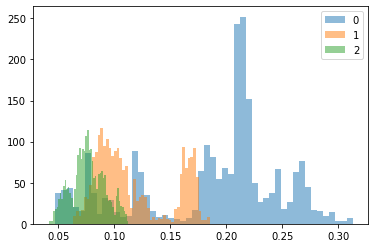

In [47]:
plt.hist(p_samples[500::2, 307], bins=50, alpha=0.5, label='0')
plt.hist(p_samples[500::2, 3],   bins=50, alpha=0.5, label='1')
plt.hist(p_samples[500::2, 105], bins=50, alpha=0.5, label='2')
plt.legend()
plt.show()

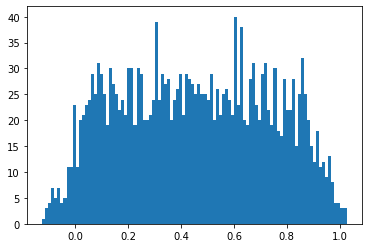

In [48]:
plt.hist(p_samples[1000:,:].mean(axis=0), bins=100)
plt.show()

**Выводы:**

к сожалению неутешительные. Эксперимент нельзя считать удавшимся, так как корреляции не приблизились к подоходам из предыдущей ДЗ. Сам алгоритм семплирования мне показался очень неустойчивым и сильно зависящим от метапараметров, которые непонятно как выбирать. 

Это довольно обидно, так как на маленьких искусственных данных сэмплирование отработало просто замечательно и дало распределения, которые очень точно отражают то, что хотелось увидеть: **игроки с меньшим кол-вом игр имеют рейтинги с бОльшей дисперсией** и поэтому даже если среднее их рейтингов больше средних рейтингов опытных игроков, это не значит, что они будут менее опытные будут иметь бОльший окончательный рейтинг - он понизится на кротное дисперсию и их "вынесет" пониже, чем опытных игроков.

**Пример:** в данных ниже игроки 0, 1 и 3 - опытные, 2 - неопытный. Игрок 2 взял все 2 вопроса, которые видел, а игрок 0 взял 4 из 5. И тем не менее распредения рейтингов по модели выше дают возможность оценить игрока 0 выше чем новичка 2.

In [49]:
fixture_data = pd.DataFrame({
    'player_id':   [0,0,0,1,1,1,3,3,3,0,0,2,2],
    'question_id': [0,1,2,0,1,2,0,1,2,3,4,3,4],
    'gameteam_id': [0,0,0,0,0,0,2,2,2,1,1,1,1],
    'win':         [1,1,0,1,1,0,0,0,0,1,1,1,1]
}).set_index(['player_id', 'question_id'])
p_ratings1, q_ratings1 = create_param_dataframes([0,0,0,0], [0,0,0,0,0])

p_samples1, q_samples1 = \
    metropolis(fixture_data, p_ratings1, q_ratings1, m_sigma=0.01,
               n_iter=8000, q_sigma=0.01, p_lam=10.0, q_lam=10.0, random_state=9)

len(p_samples1)

  1%|▏         | 119/8000 [00:00<00:48, 163.69it/s]

accept rate, %:  67
log inf rate, %:  4


  3%|▎         | 222/8000 [00:01<00:46, 167.64it/s]

accept rate, %:  85
log inf rate, %:  0


  4%|▍         | 325/8000 [00:01<00:45, 167.95it/s]

accept rate, %:  91
log inf rate, %:  0


  5%|▌         | 428/8000 [00:02<00:44, 169.11it/s]

accept rate, %:  84
log inf rate, %:  0


  7%|▋         | 530/8000 [00:03<00:44, 166.60it/s]

accept rate, %:  73
log inf rate, %:  0


  8%|▊         | 633/8000 [00:03<00:44, 166.60it/s]

accept rate, %:  89
log inf rate, %:  0


  9%|▉         | 721/8000 [00:04<00:42, 169.73it/s]

accept rate, %:  81
log inf rate, %:  0


 10%|█         | 824/8000 [00:04<00:43, 166.45it/s]

accept rate, %:  86
log inf rate, %:  0


 12%|█▏        | 928/8000 [00:05<00:41, 168.86it/s]

accept rate, %:  85
log inf rate, %:  0


 13%|█▎        | 1033/8000 [00:06<00:41, 169.48it/s]

accept rate, %:  60
log inf rate, %:  0


 14%|█▍        | 1122/8000 [00:06<00:40, 169.05it/s]

accept rate, %:  65
log inf rate, %:  0


 15%|█▌        | 1228/8000 [00:07<00:39, 169.93it/s]

accept rate, %:  77
log inf rate, %:  0


 17%|█▋        | 1333/8000 [00:07<00:39, 169.52it/s]

accept rate, %:  85
log inf rate, %:  0


 18%|█▊        | 1422/8000 [00:08<00:38, 169.48it/s]

accept rate, %:  76
log inf rate, %:  0


 19%|█▉        | 1525/8000 [00:09<00:38, 169.15it/s]

accept rate, %:  85
log inf rate, %:  0


 20%|██        | 1628/8000 [00:09<00:39, 162.64it/s]

accept rate, %:  87
log inf rate, %:  0


 22%|██▏       | 1735/8000 [00:10<00:36, 170.02it/s]

accept rate, %:  86
log inf rate, %:  0


 23%|██▎       | 1825/8000 [00:10<00:36, 170.39it/s]

accept rate, %:  92
log inf rate, %:  0


 24%|██▍       | 1933/8000 [00:11<00:35, 170.58it/s]

accept rate, %:  95
log inf rate, %:  0


 25%|██▌       | 2022/8000 [00:12<00:35, 170.57it/s]

accept rate, %:  94
log inf rate, %:  0


 27%|██▋       | 2129/8000 [00:12<00:34, 169.01it/s]

accept rate, %:  85
log inf rate, %:  0


 28%|██▊       | 2218/8000 [00:13<00:33, 170.89it/s]

accept rate, %:  79
log inf rate, %:  0


 29%|██▉       | 2324/8000 [00:13<00:33, 168.94it/s]

accept rate, %:  77
log inf rate, %:  0


 30%|███       | 2431/8000 [00:14<00:32, 169.68it/s]

accept rate, %:  79
log inf rate, %:  0


 31%|███▏      | 2519/8000 [00:14<00:32, 169.88it/s]

accept rate, %:  84
log inf rate, %:  0


 33%|███▎      | 2625/8000 [00:15<00:31, 169.77it/s]

accept rate, %:  65
log inf rate, %:  0


 34%|███▍      | 2732/8000 [00:16<00:30, 170.76it/s]

accept rate, %:  84
log inf rate, %:  0


 35%|███▌      | 2819/8000 [00:16<00:30, 168.38it/s]

accept rate, %:  78
log inf rate, %:  0


 37%|███▋      | 2926/8000 [00:17<00:29, 170.51it/s]

accept rate, %:  86
log inf rate, %:  0


 38%|███▊      | 3034/8000 [00:17<00:29, 170.43it/s]

accept rate, %:  86
log inf rate, %:  0


 39%|███▉      | 3122/8000 [00:18<00:28, 168.94it/s]

accept rate, %:  85
log inf rate, %:  0


 40%|████      | 3228/8000 [00:19<00:28, 170.41it/s]

accept rate, %:  88
log inf rate, %:  0


 42%|████▏     | 3331/8000 [00:19<00:28, 166.57it/s]

accept rate, %:  78
log inf rate, %:  0


 43%|████▎     | 3433/8000 [00:20<00:27, 167.59it/s]

accept rate, %:  81
log inf rate, %:  0


 44%|████▍     | 3518/8000 [00:20<00:26, 167.53it/s]

accept rate, %:  84
log inf rate, %:  0


 45%|████▌     | 3623/8000 [00:21<00:25, 168.85it/s]

accept rate, %:  69
log inf rate, %:  0


 47%|████▋     | 3728/8000 [00:22<00:25, 169.86it/s]

accept rate, %:  74
log inf rate, %:  0


 48%|████▊     | 3831/8000 [00:22<00:24, 167.11it/s]

accept rate, %:  84
log inf rate, %:  0


 49%|████▉     | 3933/8000 [00:23<00:24, 168.68it/s]

accept rate, %:  88
log inf rate, %:  0


 50%|█████     | 4018/8000 [00:23<00:23, 168.07it/s]

accept rate, %:  87
log inf rate, %:  0


 52%|█████▏    | 4120/8000 [00:24<00:22, 168.74it/s]

accept rate, %:  69
log inf rate, %:  0


 53%|█████▎    | 4224/8000 [00:25<00:22, 168.82it/s]

accept rate, %:  80
log inf rate, %:  0


 54%|█████▍    | 4331/8000 [00:25<00:21, 168.77it/s]

accept rate, %:  89
log inf rate, %:  0


 55%|█████▌    | 4419/8000 [00:26<00:21, 169.66it/s]

accept rate, %:  88
log inf rate, %:  0


 57%|█████▋    | 4522/8000 [00:26<00:20, 168.94it/s]

accept rate, %:  82
log inf rate, %:  0


 58%|█████▊    | 4627/8000 [00:27<00:19, 169.15it/s]

accept rate, %:  90
log inf rate, %:  0


 59%|█████▉    | 4733/8000 [00:28<00:19, 170.19it/s]

accept rate, %:  83
log inf rate, %:  0


 60%|██████    | 4823/8000 [00:28<00:18, 170.65it/s]

accept rate, %:  92
log inf rate, %:  0


 62%|██████▏   | 4931/8000 [00:29<00:17, 170.54it/s]

accept rate, %:  91
log inf rate, %:  0


 63%|██████▎   | 5021/8000 [00:29<00:17, 169.43it/s]

accept rate, %:  83
log inf rate, %:  0


 64%|██████▍   | 5128/8000 [00:30<00:16, 170.45it/s]

accept rate, %:  71
log inf rate, %:  0


 65%|██████▌   | 5233/8000 [00:31<00:16, 169.02it/s]

accept rate, %:  83
log inf rate, %:  0


 66%|██████▋   | 5320/8000 [00:31<00:15, 169.59it/s]

accept rate, %:  82
log inf rate, %:  0


 68%|██████▊   | 5424/8000 [00:32<00:15, 169.21it/s]

accept rate, %:  83
log inf rate, %:  0


 69%|██████▉   | 5529/8000 [00:32<00:14, 169.14it/s]

accept rate, %:  89
log inf rate, %:  0


 70%|███████   | 5618/8000 [00:33<00:14, 170.02it/s]

accept rate, %:  79
log inf rate, %:  0


 72%|███████▏  | 5722/8000 [00:33<00:13, 168.27it/s]

accept rate, %:  90
log inf rate, %:  0


 73%|███████▎  | 5827/8000 [00:34<00:12, 169.29it/s]

accept rate, %:  85
log inf rate, %:  0


 74%|███████▍  | 5932/8000 [00:35<00:12, 169.91it/s]

accept rate, %:  88
log inf rate, %:  0


 75%|███████▌  | 6018/8000 [00:35<00:11, 167.99it/s]

accept rate, %:  82
log inf rate, %:  0


 77%|███████▋  | 6124/8000 [00:36<00:11, 169.94it/s]

accept rate, %:  87
log inf rate, %:  0


 78%|███████▊  | 6229/8000 [00:36<00:10, 169.70it/s]

accept rate, %:  88
log inf rate, %:  0


 79%|███████▉  | 6335/8000 [00:37<00:09, 169.94it/s]

accept rate, %:  95
log inf rate, %:  0


 80%|████████  | 6424/8000 [00:38<00:09, 170.34it/s]

accept rate, %:  92
log inf rate, %:  0


 82%|████████▏ | 6532/8000 [00:38<00:08, 169.41it/s]

accept rate, %:  93
log inf rate, %:  0


 83%|████████▎ | 6621/8000 [00:39<00:08, 170.42it/s]

accept rate, %:  90
log inf rate, %:  0


 84%|████████▍ | 6727/8000 [00:39<00:07, 168.84it/s]

accept rate, %:  90
log inf rate, %:  0


 85%|████████▌ | 6829/8000 [00:40<00:06, 167.30it/s]

accept rate, %:  88
log inf rate, %:  0


 87%|████████▋ | 6931/8000 [00:41<00:06, 168.20it/s]

accept rate, %:  96
log inf rate, %:  0


 88%|████████▊ | 7033/8000 [00:41<00:05, 166.62it/s]

accept rate, %:  78
log inf rate, %:  0


 89%|████████▉ | 7118/8000 [00:42<00:05, 168.10it/s]

accept rate, %:  84
log inf rate, %:  0


 90%|█████████ | 7220/8000 [00:42<00:04, 165.76it/s]

accept rate, %:  89
log inf rate, %:  0


 92%|█████████▏| 7322/8000 [00:43<00:04, 167.91it/s]

accept rate, %:  89
log inf rate, %:  0


 93%|█████████▎| 7427/8000 [00:44<00:03, 169.85it/s]

accept rate, %:  92
log inf rate, %:  0


 94%|█████████▍| 7531/8000 [00:44<00:02, 168.05it/s]

accept rate, %:  91
log inf rate, %:  0


 95%|█████████▌| 7619/8000 [00:45<00:02, 169.59it/s]

accept rate, %:  91
log inf rate, %:  0


 97%|█████████▋| 7723/8000 [00:45<00:01, 168.68it/s]

accept rate, %:  87
log inf rate, %:  0


 98%|█████████▊| 7827/8000 [00:46<00:01, 169.68it/s]

accept rate, %:  89
log inf rate, %:  0


 99%|█████████▉| 7932/8000 [00:47<00:00, 169.22it/s]

accept rate, %:  78
log inf rate, %:  0


100%|██████████| 8000/8000 [00:47<00:00, 168.77it/s]


6722

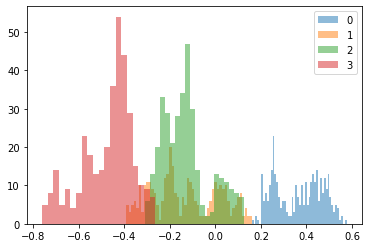

In [50]:
plt.hist(p_samples1[5000::5, 0], bins=50, alpha=0.5, label='0')
plt.hist(p_samples1[5000::5, 1], bins=50, alpha=0.5, label='1')
plt.hist(p_samples1[5000::5, 2], bins=20, alpha=0.5, label='2')
plt.hist(p_samples1[5000::5, 3], bins=20, alpha=0.5, label='3')
plt.legend()
plt.show()

**Жаль, что на полноразмерной модели что-то не срослось, и получить аналогичных картин не вышло. Подучилось бы довольно красиво и замкнуто теоретически.**

## Выводы:

- Сэмплирование - очень мощный и универсальный инструмент как для решения задач, которые иначе решить нельзя, так и для получения вероятностных на 
- Но, увы, довольно неустойчивый... Может не сойтись, могут существенно повлиять априорные распределения или гиперпараметры сэмплирования и т.п.

**P.S. Спасибо за очень интересный курс. Стали видны новые горизонты ML как области знаний и существенно расширился кругозор.**